In [73]:
import tensorflow as tf
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal
from scipy.ndimage import uniform_filter
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method
from scipy.ndimage import uniform_filter
from scipy.signal import butter, filtfilt, lfilter
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [23]:
def load_model(model_path):
    if not tf.io.gfile.exists(model_path):
        raise FileNotFoundError(f"Model file {model_path} not found.")
    
    model = tf.keras.models.load_model(model_path, compile=False)
    return model

In [24]:
def resample_signal(original_signal, original_fs, target_fs=100):
    if original_fs == target_fs:
        return original_signal

    fs_ratio = TARGET_FS/original_fs
    ecg_resamp = signal.resample(ecg,int(ecg.shape[0]*fs_ratio), axis=0)
    
    return ecg_resamp

In [25]:
def adjust_signal_length(signal, target_length):
    current_length = signal.shape[0]
    if current_length < target_length:
        print(f"Padding signal from {current_length} to {target_length} samples")
        return np.pad(signal, ((0, target_length - current_length), (0, 0)), mode='constant')

    ecg_pad = tf.keras.utils.pad_sequences(
        np.moveaxis(signal,0,-1),
        maxlen=target_length,
        dtype='float32',
        padding='post',
        truncating='post',
        value=0.0)
    
    ecg_pad = np.moveaxis(ecg_pad,0,-1)

    return ecg_pad

In [26]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv1D):
            return layer.name
    raise ValueError("No convolutional layer found in the model.")

In [27]:
def compute_grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        class_output = preds[:, class_idx]
    
    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    
    conv_output = conv_outputs[0].numpy()
    conv_output *= pooled_grads.numpy()
    
    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-8)
    
    return heatmap, class_idx.numpy()

In [28]:
def plot_ecg_with_gradcam(signal, heatmap, lead_names, fs, class_idx):
    num_leads = signal.shape[1]
    time = np.arange(signal.shape[0]) / fs
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(num_leads, 1, figure=fig)
    heatmap_normalized = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-8)
    for lead in range(num_leads):
        ax = fig.add_subplot(gs[lead, 0])
        vertical_offset = lead * 3
        ax.plot(time, signal[:, lead] + vertical_offset, linewidth=1, color='black')
        heatmap_extent = [time[0], time[-1], vertical_offset - 1.5, vertical_offset + 1.5]
        ax.imshow(
            np.expand_dims(heatmap_normalized, axis=0),
            cmap='viridis',
            aspect='auto',
            extent=heatmap_extent,
            alpha=0.4,
            origin='lower'
        )
        ax.set_ylabel(lead_names[lead], rotation=0, ha='right', va='center')
        ax.set_yticks([])
        ax.set_ylim(vertical_offset - 2, vertical_offset + 2)
        if lead != num_leads - 1:
            ax.set_xticks([])
    plt.suptitle(f"Predicted Class: {class_idx}\nGrad-CAM Heatmap Overlay", y=0.92)
    plt.xlabel("Time (seconds)")
    plt.tight_layout()
    plt.show()

In [29]:
#Helper
def get_header_file(record):
    if not record.endswith('.hea'):
        header_file = record + '.hea'
    else:
        header_file = record
    return header_file

def load_text(filename):
    with open(filename, 'r') as f:
        string = f.read()
    return string

def load_header(record):
    header_file = get_header_file(record)
    header = load_text(header_file)
    return header

def load_signals(record):
    signal, fields = wfdb.rdsamp(record)
    return signal, fields

def get_variable(string, variable_name):
    variable = ''
    has_variable = False
    for l in string.split('\n'):
        if l.startswith(variable_name):
            variable = l[len(variable_name):].strip()
            has_variable = True
    return variable, has_variable

def remove_extra_characters(x):
    x = str(x)
    x = x.replace('"', '').replace("'", "")
    x = x.replace('(', '').replace(')', '').replace('[', '').replace(']', '').replace('{', '').replace('}', '')
    x = x.replace(' ', '').replace('\t', '')
    x = x.strip()
    return x

def is_number(x):
    try:
        float(x)
        return True
    except (ValueError, TypeError):
        return False

def sanitize_boolean_value(x):
    x = remove_extra_characters(x)
    if (is_number(x) and float(x)==0) or (remove_extra_characters(x).casefold() in ('false', 'f', 'no', 'n')):
        return 0
    elif (is_number(x) and float(x)==1) or (remove_extra_characters(x).casefold() in ('true', 't', 'yes', 'y')):
        return 1
    else:
        return float('nan')

def get_label(string, allow_missing=False):
    label, has_label = get_variable(string, label_string)
    if not has_label and not allow_missing:
        raise Exception('No label is available: are you trying to load the labels from the held-out data?')
    label = sanitize_boolean_value(label)
    return label

def load_label(record):
    header = load_header(record)
    label = get_label(header)
    return label

In [30]:
# Configuration
MODEL_PATH = "./model/model.keras"
RECORD_PATH = "./input/14"
REQUIRED_LENGTH = 1000
NUM_SAMPLES_TO_PLOT = 1
TARGET_FS = 100

In [31]:
ecg , text= load_signals(RECORD_PATH)
fs = int(text["fs"])

try:
    # Load model and data
    model = load_model(MODEL_PATH)
    ecg , text= load_signals(RECORD_PATH)
    
    conv_layer_name = find_last_conv_layer(model)
    
    # Validate ECG signal dimensions
    original_signal = ecg
    original_fs = int(text["fs"])
    
    if original_signal.ndim != 2 or original_signal.shape[1] != 12:
        raise ValueError("ECG signal must have shape (samples, 12 leads).")

except Exception as e:
    print(f"Error loading model or data: {str(e)}")

Resampled samples: 1024, Target FS: 100
Original Signal - Predicted Class: 0


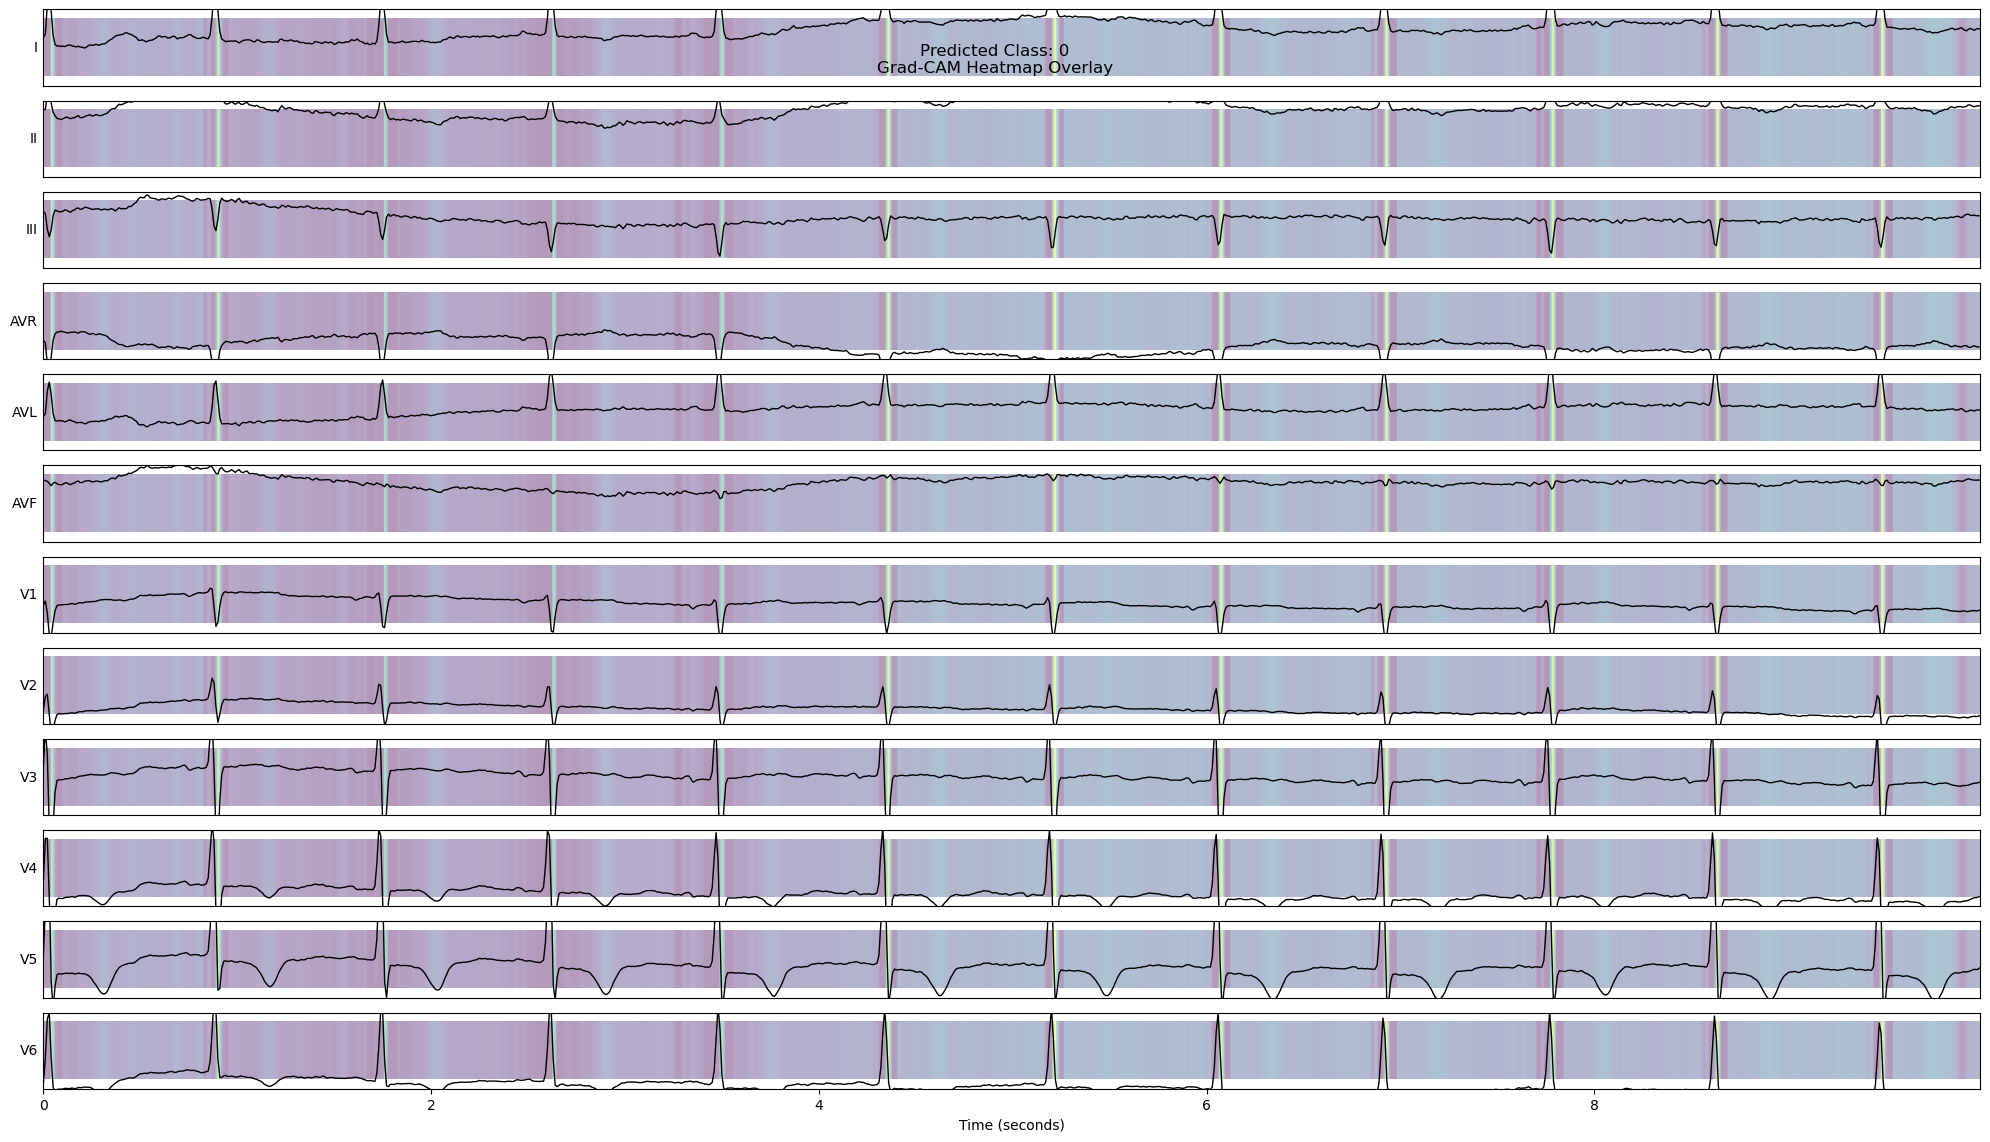

In [32]:
try:    
    # Resample and process signal
    resampled_signal = resample_signal(original_signal, original_fs, TARGET_FS)
    total_samples = resampled_signal.shape[0]
    
    print(f"Resampled samples: {total_samples}, Target FS: {TARGET_FS}")
    
    adjusted_signal = adjust_signal_length(resampled_signal, REQUIRED_LENGTH)
    
    input_tensor = tf.convert_to_tensor(
        np.expand_dims(adjusted_signal, 0), dtype=tf.float32
    )
    
    # Compute Grad-CAM
    heatmap_original, class_idx_original = compute_grad_cam(model, input_tensor, conv_layer_name)
    
    # Plot Grad-CAM
    print(f"Original Signal - Predicted Class: {class_idx_original}")
    plot_ecg_with_gradcam(
        adjusted_signal,
        heatmap_original,
        text['sig_name'],
        TARGET_FS,
        class_idx=class_idx_original)
        
except Exception as main_error:
    print(f"Critical error: {str(main_error)}")

In [33]:
probability_output = model.predict(input_tensor)

print("Predicted probabilities:", probability_output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Predicted probabilities: [[0.00012182]]


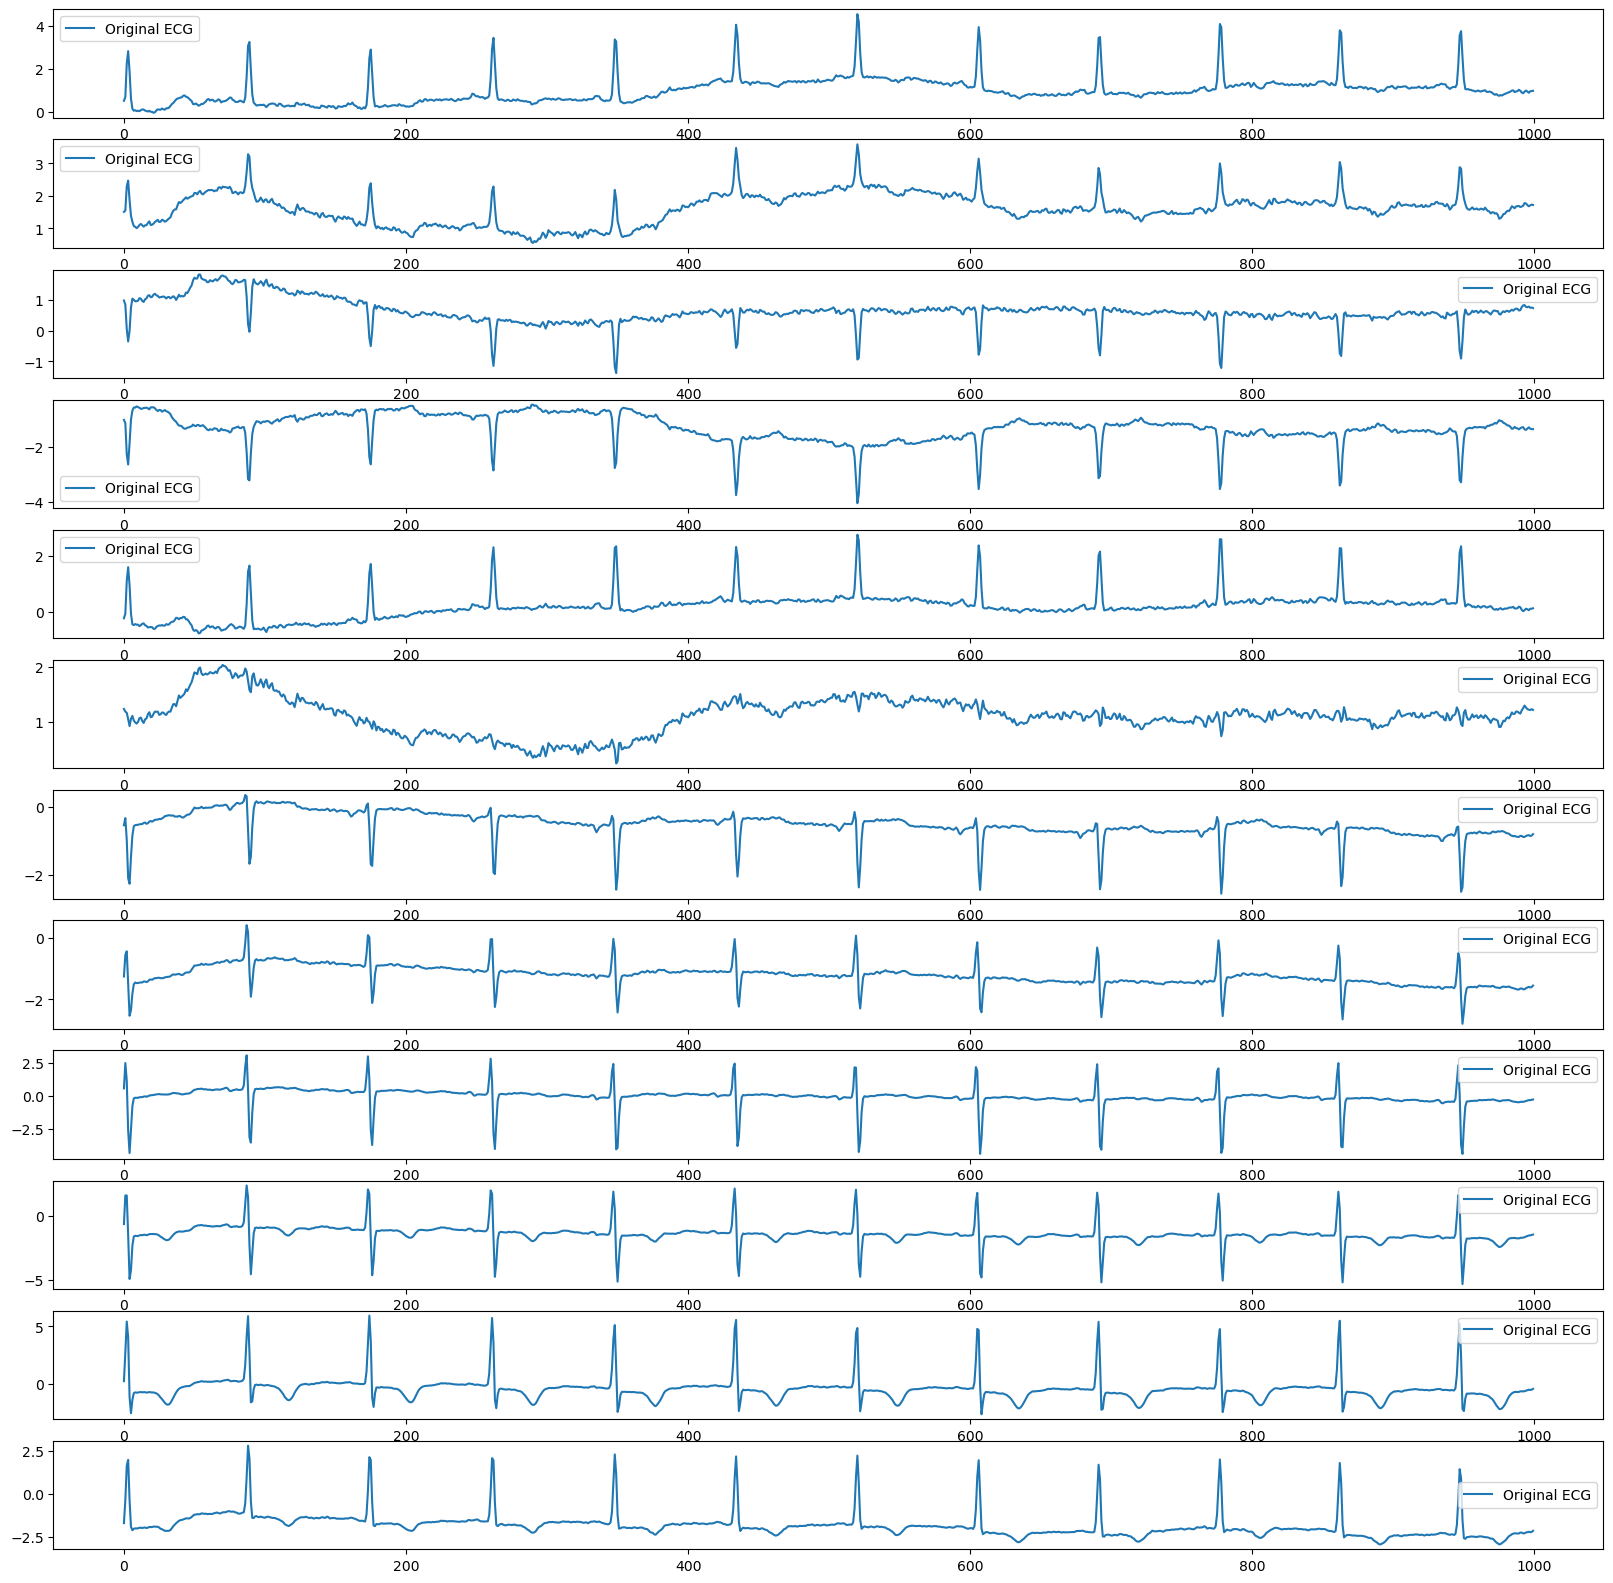

In [34]:
plt.figure(figsize=(20,20))
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.asarray(adjusted_signal)[:,i], label= "Original ECG")
    plt.legend()

In [35]:
def optimize_linear(grad, eps):
    """
    Solves for the optimal input to a linear function under a norm constraint.

    Optimal_perturbation = argmax_{eta, ||eta||_{norm} < eps} dot(eta, grad)

    :param grad: tf tensor containing a batch of gradients
    :param eps: float scalar specifying size of constraint region
    :param norm: int specifying order of norm
    :returns:
      tf tensor containing optimal perturbation
    """

    # Convert the iterator returned by `range` into a list.
    axis = list(range(1, len(grad.get_shape())))
    avoid_zero_div = 1e-12

    # Take sign of gradient
    optimal_perturbation = tf.sign(grad)
    # The following line should not change the numerical results. It applies only because
    # `optimal_perturbation` is the output of a `sign` op, which has zero derivative anyway.
    # It should not be applied for the other norms, where the perturbation has a non-zero derivative.
    optimal_perturbation = tf.stop_gradient(optimal_perturbation)
    
    # Scale perturbation to be the solution for the norm=eps rather than norm=1 problem
    scaled_perturbation = tf.multiply(eps, optimal_perturbation)
    return scaled_perturbation

In [36]:
def bandpass_filter(signal, lowcut=0.5, highcut=50, fs=500, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

In [37]:
num_epochs = 100
eps = 0.01
data_example = np.expand_dims(adjusted_signal,0)
#pred_example = y_data
desired_pred = np.array([[1]])

data_example = tf.convert_to_tensor(data_example, dtype=tf.float32)

adv_x = data_example

while model.predict(adv_x)[0][0] < 0.01:
    print(model.predict(adv_x))
    with tf.GradientTape() as tape:
      tape.watch(adv_x)
      pred = model(adv_x)
      loss = tf.keras.losses.binary_crossentropy(desired_pred, pred)
      loss = -loss
      #print(np.asarray(loss))
    grads = tape.gradient(loss, adv_x)
    #print(grads)
    optimal_perturbation = optimize_linear(grads, eps)
    #optimal_perturbation = uniform_filter(optimal_perturbation[0], 15, mode='constant')
    print(optimal_perturbation.shape)
    optimal_perturbation_filtered = np.array([bandpass_filter(optimal_perturbation[0,:,i], fs=fs) for i in range(12)])
    optimal_perturbation_filtered = np.expand_dims(np.moveaxis(optimal_perturbation_filtered,0,-1),0)
    #print(optimal_perturbation)
    # Add perturbation to original example to obtain adversarial example
    adv_x = adv_x + optimal_perturbation_filtered

    adv_x = tf.convert_to_tensor(adv_x)
    # Ensure plausible values (might be something else than -2 to 5)
    #adv_x = tf.clip_by_value(adv_x, -2,5)

    #opt.apply_gradients(zip(grads, model.trainable_variables))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.00012182]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.00013884]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[0.0001591]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.00018311]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.00021134]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[0.00024446]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[0.00028287]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.00032762]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.0003815]]
(1, 1000, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━

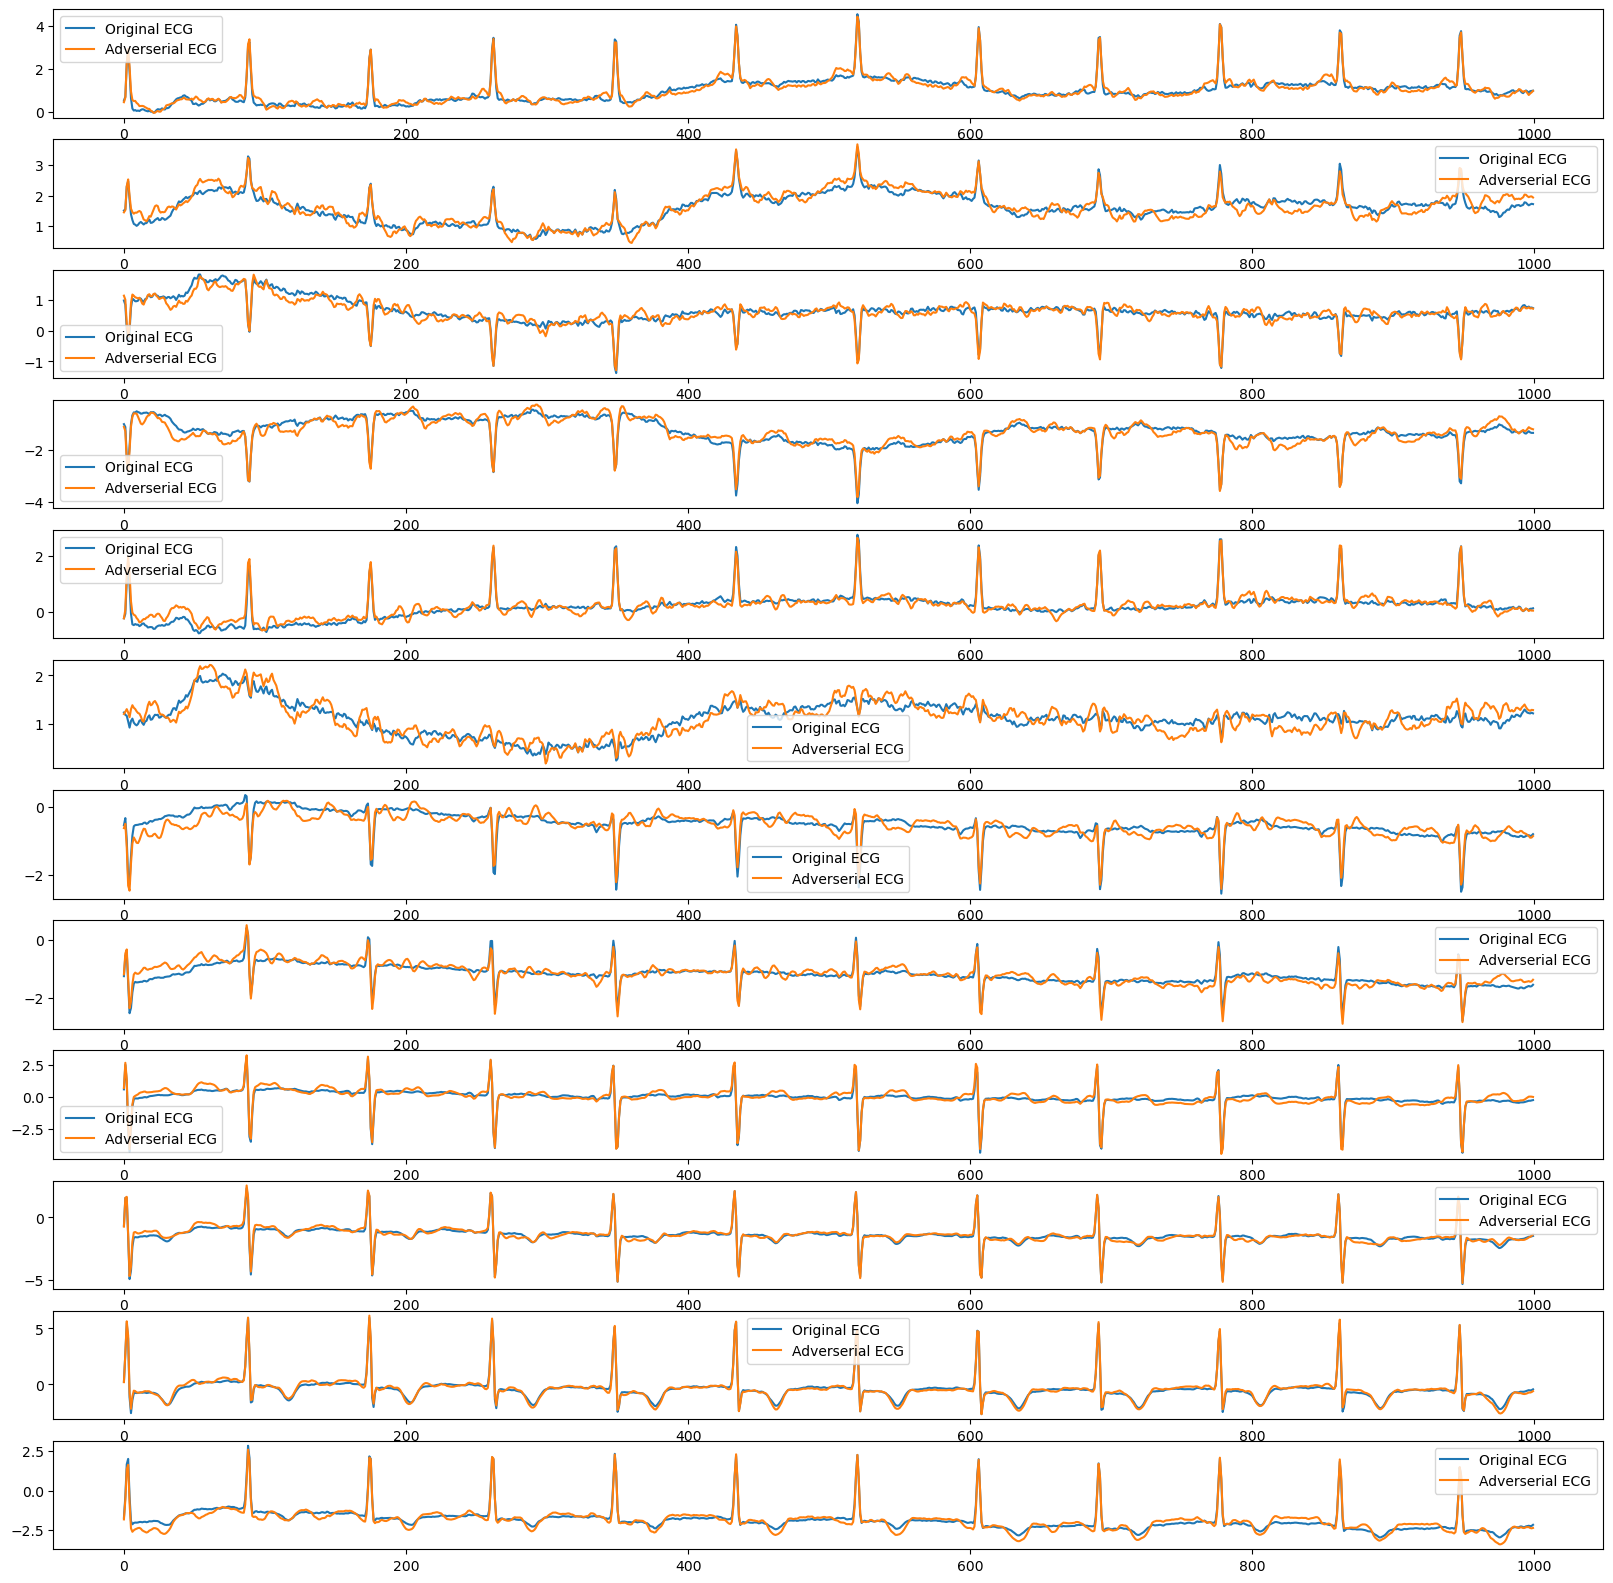

In [38]:
plt.figure(figsize=(20,20))
#adv_x = bandpass_filter(adv_x)
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.asarray(data_example)[0,:,i], label= "Original ECG")
    plt.plot(np.asarray(adv_x)[0,:,i], label= "Adverserial ECG")
    plt.legend()

In [89]:
y_hat = model.predict(input_tensor)
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


array([[0.00012182]], dtype=float32)

In [49]:
input_tensor.shape

TensorShape([1, 1000, 12])

In [88]:
y_test = np.ones((input_tensor.shape[0], 1))
y_test

array([[1.]])

In [51]:
def binary_crossentropy_loss(labels, logits):
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return loss_fn(y_true=labels, y_pred=logits)

In [58]:
epsilon = 0.2
adv_x_test = fast_gradient_method(
    model, 
    input_tensor, 
    epsilon, 
    np.inf, 
    loss_fn=binary_crossentropy_loss
)

In [59]:
# Predict on adversarial example
adv_pred = model.predict(adv_x_test)
print("Adversarial Prediction:", adv_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Adversarial Prediction: [[0.00157682]]


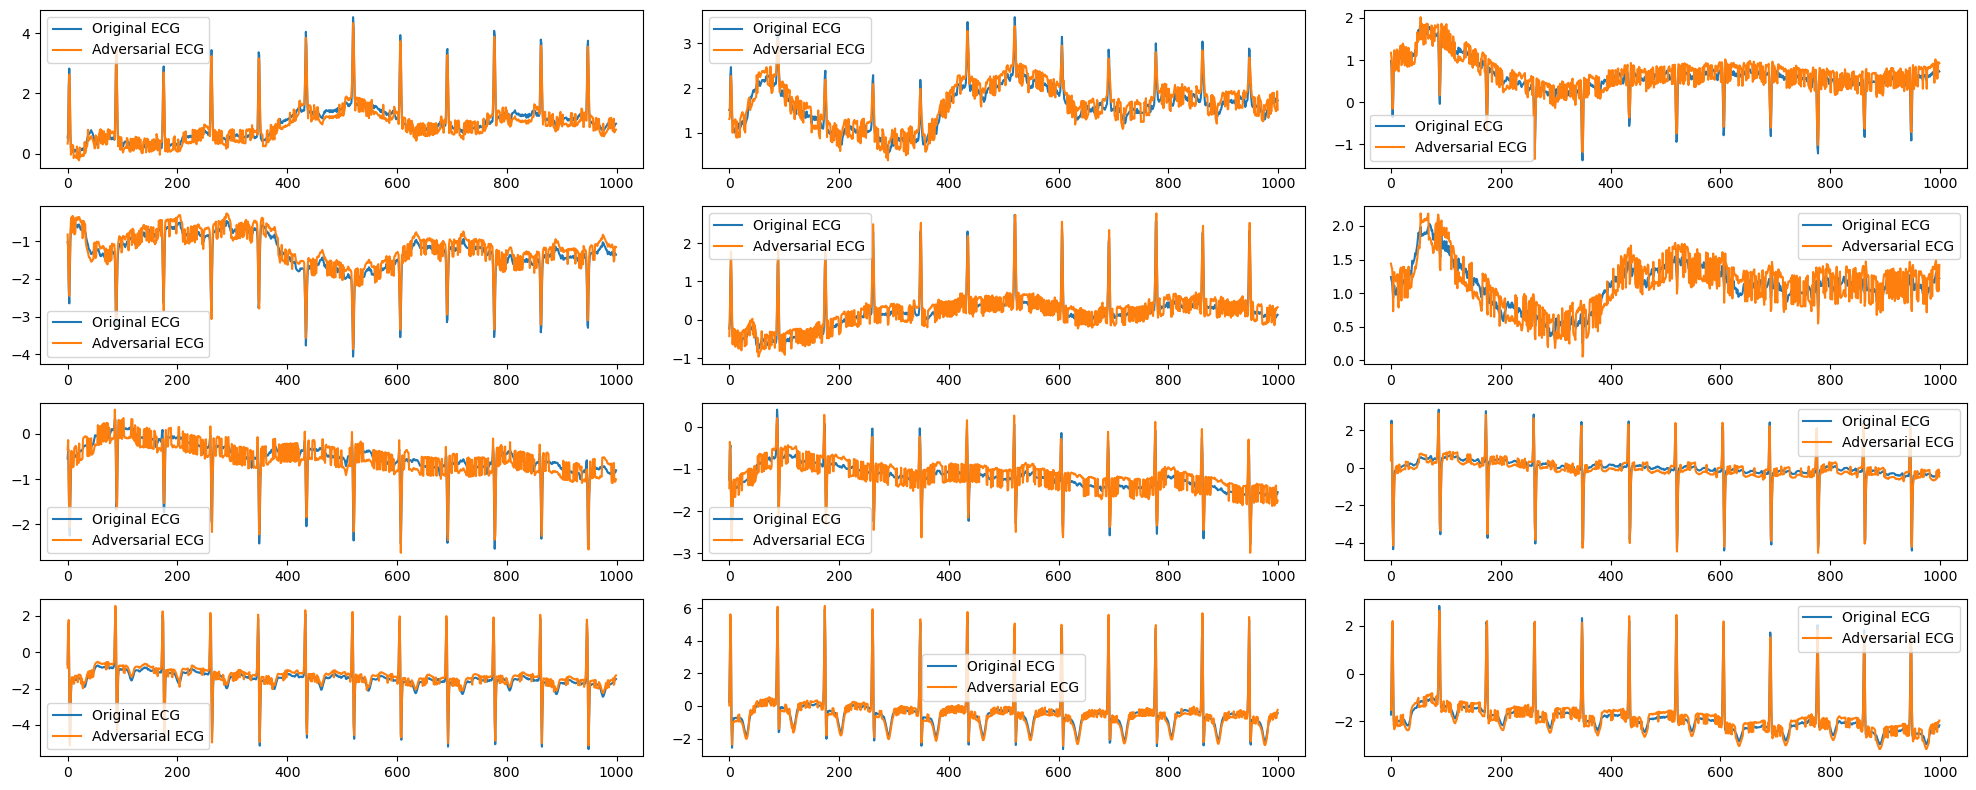

In [60]:
# Visualize original vs. adversarial ECG signals
plt.figure(figsize=(20, 8))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.plot(input_tensor[0][:, i], label="Original ECG")
    plt.plot(adv_x_test[0][:, i], label="Adversarial ECG")
    plt.legend()
plt.tight_layout()
plt.show()

In [68]:
# Evaluate model performance on original and adversarial data
original_pred = (y_hat > 0.01).astype(int)  # Threshold for binary classification
adv_pred_class = (adv_pred > 0.01).astype(int)

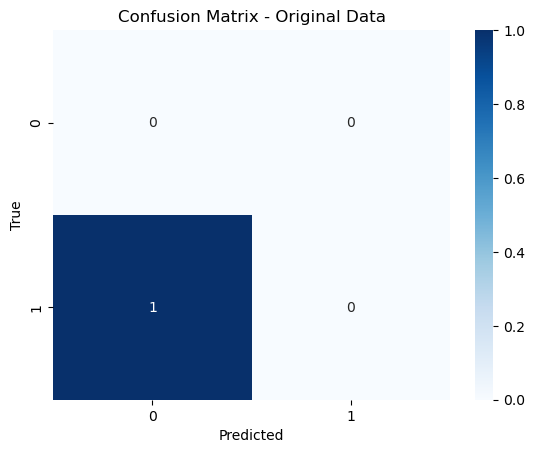

In [69]:
# Confusion matrix for original data
cm_original = confusion_matrix(y_test, original_pred)
sns.heatmap(cm_original, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Original Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

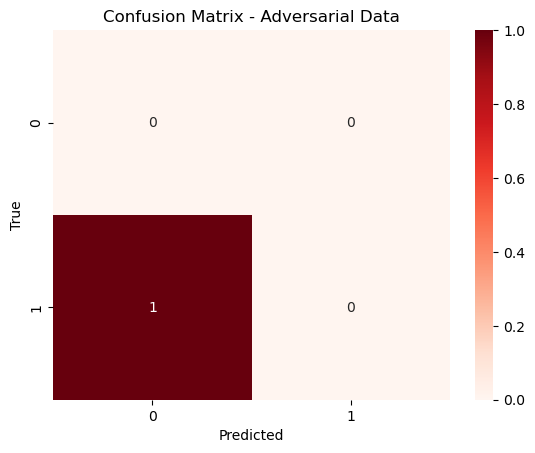

In [70]:
# Confusion matrix for adversarial data
cm_adv = confusion_matrix(y_test, adv_pred_class)
sns.heatmap(cm_adv, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix - Adversarial Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [71]:
# Apply low-pass filtering to adversarial examples
cutoff = 40  # Cutoff frequency (Hz)
fs = 100     # Sampling frequency (Hz)
order = 2    # Filter order

In [74]:
b, a = butter(order, cutoff / (fs / 2), btype='low')
filtered_adv = np.zeros_like(adv_x_test)
for i in range(12):
    filtered_adv[:, :, i] = lfilter(b, a, adv_x_test[:, :, i], axis=1)

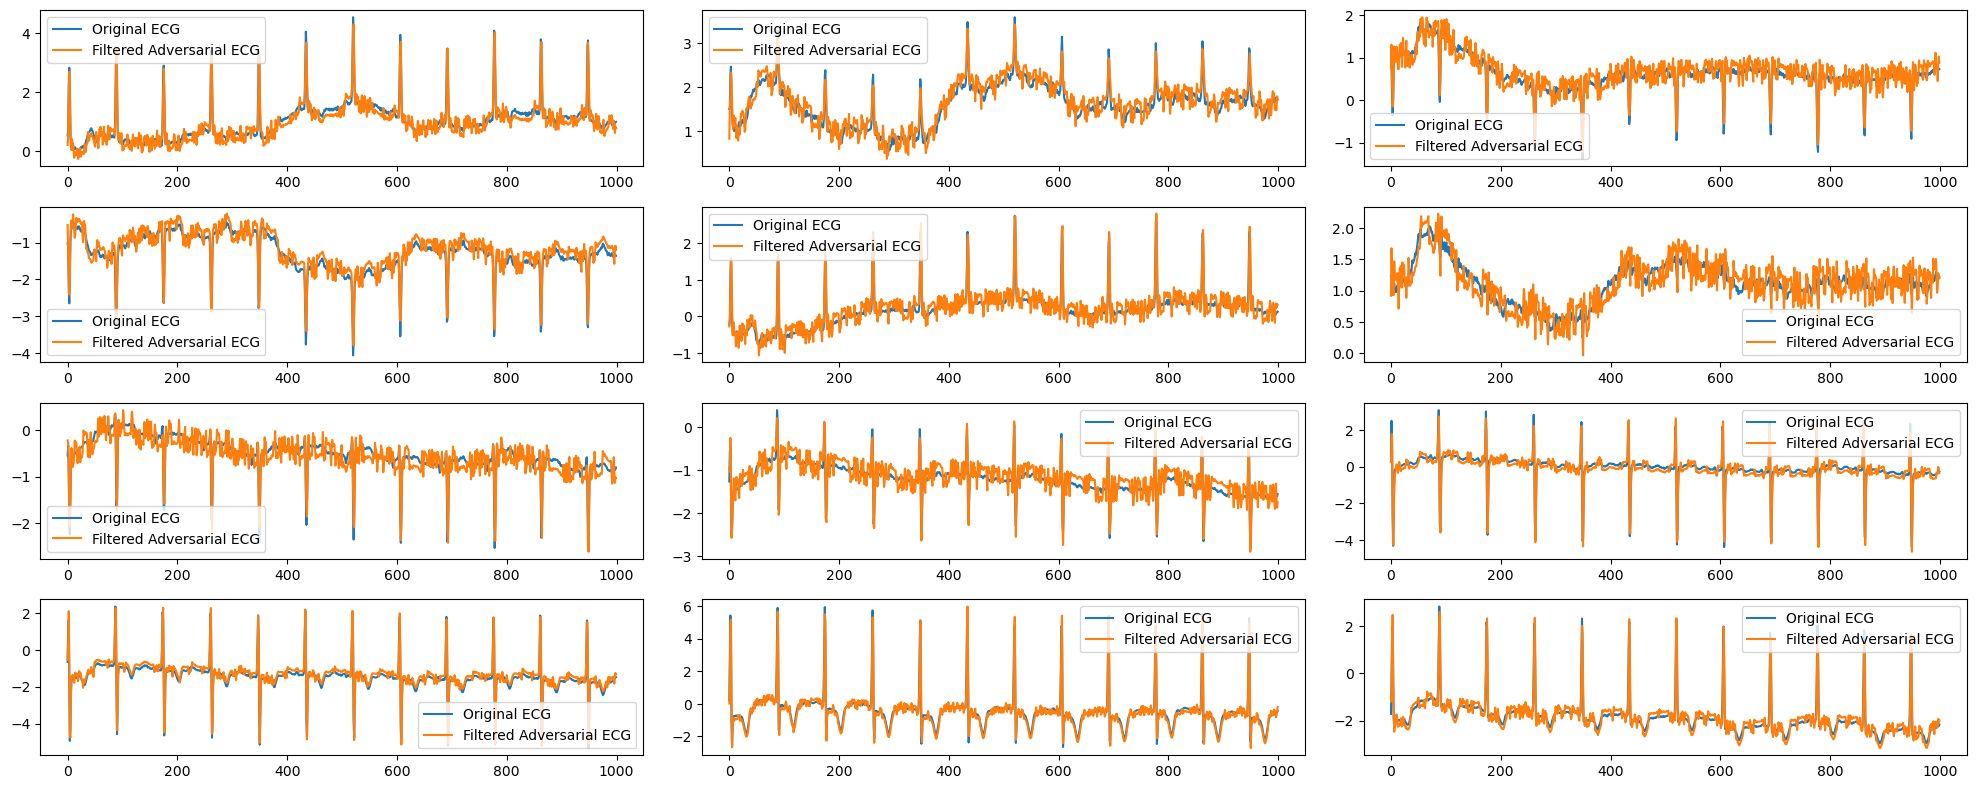

In [76]:
# Plot filtered adversarial signal
plt.figure(figsize=(20, 8))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.plot(input_tensor[0][:, i], label="Original ECG")
    plt.plot(filtered_adv[0][:, i], label="Filtered Adversarial ECG")
    plt.legend()
plt.tight_layout()
plt.show()

In [87]:
epsilon = 0.2
num = 1
target_adv = np.zeros((num,), dtype=np.int32)  # Shape: (num,), dtype: int32
TARGET_CLASS = 1  # Example target class (1 for positive class)
target_adv[:] = TARGET_CLASS  # Set all targets to the desired class

# Ensure the model's output layer is configured for binary classification
# Example: model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

adv_x_test_bim = basic_iterative_method(
    model, input_tensor[:num], eps=epsilon, eps_iter=0.01, nb_iter=250,
    norm=np.inf, y=target_adv, targeted=True, sanity_checks=False
)

2025-02-23 11:55:19.901156: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 1


InvalidArgumentError: Graph execution error:

Detected at node SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/anaconda3/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/anaconda3/lib/python3.12/asyncio/base_events.py", line 639, in run_forever

  File "/opt/anaconda3/lib/python3.12/asyncio/base_events.py", line 1985, in _run_once

  File "/opt/anaconda3/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/xp/8km2sz2x3_13p1wxkyv5xqlc0000gn/T/ipykernel_1316/2364731288.py", line 7, in <module>

  File "/opt/anaconda3/lib/python3.12/site-packages/cleverhans/tf2/attacks/basic_iterative_method.py", line 26, in basic_iterative_method

  File "/opt/anaconda3/lib/python3.12/site-packages/cleverhans/tf2/attacks/projected_gradient_descent.py", line 107, in projected_gradient_descent

  File "/opt/anaconda3/lib/python3.12/site-packages/cleverhans/tf2/attacks/fast_gradient_method.py", line 65, in fast_gradient_method

  File "/opt/anaconda3/lib/python3.12/site-packages/cleverhans/tf2/utils.py", line 187, in compute_gradient

Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 1
	 [[{{node SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_compute_gradient_176587]